# **Homework 10 - Adversarial Attack**

Slides: https://reurl.cc/v5kXkk

Video(En): https://youtu.be/313TZsUDQ48

Video(Zh): https://youtu.be/xWHpPEvkDiE

TA: ntu-ml-2021spring-ta@googlegroups.com

## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

In [ ]:
!nvidia-smi

Fri May 28 08:17:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# set up environment
!pip install pytorchcv

# download
!gdown --id 1fHi1ko7wr80wXkXpqpqpOxuYH1mClXoX -O data.zip

# unzip
!unzip ./data.zip
!rm ./data.zip

     |████████████████████████████████| 532kB 14.3MB/s 
Downloading...
From: https://drive.google.com/uc?id=1fHi1ko7wr80wXkXpqpqpOxuYH1mClXoX
To: /content/data.zip
100% 490k/490k [00:00<00:00, 65.6MB/s]
Archive:  ./data.zip
   creating: data/
   creating: data/deer/
 extracting: data/deer/deer13.png    
 extracting: data/deer/deer6.png     
 extracting: data/deer/deer11.png    
 extracting: data/deer/deer2.png     
 extracting: data/deer/deer10.png    
 extracting: data/deer/deer16.png    
 extracting: data/deer/deer9.png     
 extracting: data/deer/deer20.png    
 extracting: data/deer/deer15.png    
 extracting: data/deer/deer19.png    
 extracting: data/deer/deer5.png     
 extracting: data/deer/deer14.png    
 extracting: data/deer/deer4.png     
 extracting: data/deer/deer8.png     
 extracting: data/deer/deer12.png    
 extracting: data/deer/deer1.png     
 extracting: data/deer/deer7.png     
 extracting: data/deer/deer17.png    
 extracting: data/deer/deer18.png    
 extracting

## Global Settings

* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 1

# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std
# TODO: iterative fgsm attack
# alpha (step size) can be decided by yourself
alpha = 0.3/255/std

root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [ ]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


## Utils -- Benign Images Evaluation

In [ ]:
# to evaluate the performance of model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

## Utils -- Attack Algorithm

In [ ]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    x_adv = x_adv + epsilon * x_adv.grad.detach().sign()
    return x_adv

# TODO: perform iterative fgsm attack
# set alpha as the step size in Global Settings section
# alpha and num_iter can be decided by yourself
def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=50):
    # initialize x_adv as original benign image x
    # write a loop of num_iter to represent the iterative times
    # for each loop
        # call fgsm with (epsilon = alpha) to obtain new x_adv
        # clip new x_adv back to [x-epsilon, x+epsilon]
    x_adv = x
    for _ in range(num_iter):
      x_adv = fgsm(model, x_adv, y, loss_fn, alpha)
      x_adv = torch.min(torch.max(x_adv, x - epsilon), x + epsilon)
    return x_adv

def mifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=70):
    # initialize x_adv as original benign image x
    # write a loop of num_iter to represent the iterative times
    # for each loop
        # call fgsm with (epsilon = alpha) to obtain new x_adv
        # clip new x_adv back to [x-epsilon, x+epsilon]
    x_adv = x
    g = None
    for _ in range(num_iter):
      x_adv_ = x_adv.detach().clone() # initialize x_adv as original benign image x
      x_adv_.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
      loss = loss_fn(model(x_adv_), y) # calculate loss
      loss.backward() # calculate gradient
      # fgsm: use gradient ascent on x_adv to maximize loss
      if g == None:
        g = x_adv_.grad.detach()
      else:
        g = g + 0.9 * x_adv_.grad.data / torch.norm(x_adv_.grad.data, p = 1)
      x_adv = x_adv + alpha * torch.sign(g)
      x_adv = torch.min(torch.max(x_adv, x - epsilon), x + epsilon)
    return x_adv
    

## Utils -- Attack

* Recall
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.

* Inverse function
    * Inverse Normalize() can be seen as a function where $N^{-1}(x) = x*std+mean$ where $mean$ and $std$ are constants.
    * Inverse ToTensor() can be seen as a function where $T^{-1}(x) = x*255$.

* Special Noted
    * ToTensor() will also convert the image from shape (height, width, channel) to shape (channel, height, width), so we also need to transpose the shape back to original shape.
    * Since our dataloader samples a batch of data, what we need here is to transpose **(batch_size, channel, height, width)** back to **(batch_size, height, width, channel)** using np.transpose.

In [ ]:
import tqdm
import random
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(tqdm.tqdm(loader)):
        x, y = x.to(device), y.to(device)
        x_advs = []
        losses = []
        yps = []
        for m in models:
          m.eval()
          x_adv = attack(m, x, y, loss_fn) # obtain adversarial examples
          yp = torch.zeros(10).to(device)
          for mm in models:
            mm.eval()
            yp[mm(x_adv).argmax(dim=1).item()] += 1
          losses.append(loss_fn(yp.unsqueeze(0), y))
          x_advs.append(x_adv)
          yps.append(yp)
        best_loss, best_idx = torch.max(torch.tensor(losses), dim = 0)
        print(yps[best_idx], y)
        train_acc += (yps[best_idx].argmax(dim=0) == y).sum().item()
        train_loss += best_loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_advs[best_idx]) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

In [ ]:
from pytorchcv.model_provider import get_model as ptcv_get_model

model = ptcv_get_model('resnet1202_cifar10', pretrained=True).to(device)
models = [
#ptcv_get_model('resnet1202_cifar10', pretrained=True).to(device),
ptcv_get_model('resnet542bn_cifar10', pretrained=True).to(device),
ptcv_get_model('resnet56_cifar10', pretrained=True).to(device),
ptcv_get_model('nin_cifar10', pretrained=True).to(device),
ptcv_get_model('densenet40_k24_bc_cifar10', pretrained=True).to(device),
ptcv_get_model('resnext272_2x32d_cifar10', pretrained=True).to(device),
ptcv_get_model('ror3_110_cifar10', pretrained=True).to(device),
ptcv_get_model('pyramidnet272_a200_bn_cifar10', pretrained=True).to(device),
ptcv_get_model('wrn20_10_32bit_cifar10', pretrained=True).to(device),
ptcv_get_model('diapreresnet164bn_cifar10', pretrained=True).to(device),
ptcv_get_model('preresnet542bn_cifar10', pretrained=True).to(device),
ptcv_get_model('seresnet164bn_cifar10', pretrained=True).to(device),
ptcv_get_model('diaresnet164bn_cifar10', pretrained=True).to(device),
ptcv_get_model('xdensenet40_2_k24_bc_cifar10', pretrained=True).to(device),
ptcv_get_model('sepreresnet110_cifar10', pretrained=True).to(device),
ptcv_get_model('wrn28_10_cifar10', pretrained=True).to(device),
ptcv_get_model('rir_cifar10', pretrained=True).to(device)
]
loss_fn = nn.CrossEntropyLoss()

## FGSM

In [ ]:
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsm', adv_examples, adv_names)

  0%|          | 0/200 [00:00<?, ?it/s]

tensor([8., 0., 1., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')
tensor([5., 0., 2., 0., 0., 0., 1., 0., 2., 0.], device='cuda:0')
tensor([7., 0., 0., 0., 0., 0., 1., 0., 2., 0.], device='cuda:0')
tensor([7., 0., 0., 1., 0., 0., 0., 0., 2., 0.], device='cuda:0')
tensor([7., 0., 2., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')
tensor([2., 0., 7., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')
tensor([6., 0., 2., 0., 0., 0., 1., 0., 1., 0.], device='cuda:0')
tensor([7., 0., 1., 1., 0., 0., 0., 0., 1., 0.], device='cuda:0')
tensor([8., 0., 0., 1., 0., 0., 1., 0., 0., 0.], device='cuda:0')


  0%|          | 1/200 [00:05<17:51,  5.39s/it]

tensor([7., 0., 0., 2., 0., 0., 0., 0., 0., 1.], device='cuda:0')
tensor([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')


  1%|          | 2/200 [00:10<17:18,  5.24s/it]

tensor([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')


KeyboardInterrupt: ignored

## I-FGSM

In [ ]:
# TODO: iterative fgsm attack
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, mifgsm, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsm', adv_examples, adv_names)




  0%|          | 0/200 [00:00<?, ?it/s]


  0%|          | 1/200 [01:07<3:43:03, 67.25s/it]

tensor([ 0.,  0., 15.,  0.,  0.,  0.,  0.,  0.,  0.,  1.], device='cuda:0') tensor([0], device='cuda:0')





  1%|          | 2/200 [02:14<3:42:21, 67.38s/it]

tensor([10.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  2%|▏         | 3/200 [03:27<3:46:03, 68.85s/it]

tensor([3., 0., 6., 7., 0., 0., 0., 0., 0., 0.], device='cuda:0') tensor([0], device='cuda:0')





  2%|▏         | 4/200 [04:42<3:51:02, 70.73s/it]

tensor([ 0.,  0.,  0.,  1., 15.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  2%|▎         | 5/200 [05:56<3:53:00, 71.70s/it]

tensor([ 0.,  0., 15.,  0.,  0.,  0.,  0.,  0.,  1.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  3%|▎         | 6/200 [07:09<3:53:40, 72.27s/it]

tensor([ 2.,  0., 12.,  2.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  4%|▎         | 7/200 [08:23<3:53:54, 72.72s/it]

tensor([ 1.,  1.,  0., 13.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  4%|▍         | 8/200 [09:37<3:53:31, 72.98s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  4%|▍         | 9/200 [10:48<3:51:08, 72.61s/it]

tensor([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 15.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  5%|▌         | 10/200 [11:57<3:45:49, 71.31s/it]

tensor([ 1.,  0.,  0.,  0., 15.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  6%|▌         | 11/200 [13:04<3:41:13, 70.23s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 15.,  1.], device='cuda:0') tensor([0], device='cuda:0')





  6%|▌         | 12/200 [14:13<3:38:08, 69.62s/it]

tensor([ 0.,  0.,  0.,  1.,  0., 15.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  6%|▋         | 13/200 [15:20<3:35:09, 69.04s/it]

tensor([ 1.,  0.,  0.,  2.,  0.,  0.,  0., 11.,  2.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  7%|▋         | 14/200 [16:27<3:32:04, 68.41s/it]

tensor([ 2.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  8%|▊         | 15/200 [17:34<3:29:46, 68.03s/it]

tensor([ 3.,  0.,  0.,  0., 11.,  0.,  2.,  0.,  0.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  8%|▊         | 16/200 [18:42<3:27:56, 67.81s/it]

tensor([13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  8%|▊         | 17/200 [19:49<3:26:39, 67.76s/it]

tensor([ 0.,  0., 15.,  1.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([0], device='cuda:0')





  9%|▉         | 18/200 [20:56<3:24:44, 67.50s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.], device='cuda:0') tensor([0], device='cuda:0')





 10%|▉         | 19/200 [22:03<3:23:05, 67.32s/it]

tensor([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  0.], device='cuda:0') tensor([0], device='cuda:0')





 10%|█         | 20/200 [23:10<3:21:43, 67.24s/it]

tensor([ 1.,  0., 15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([0], device='cuda:0')





 10%|█         | 21/200 [24:18<3:20:59, 67.37s/it]

tensor([ 0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,  4.], device='cuda:0') tensor([1], device='cuda:0')





 11%|█         | 22/200 [25:25<3:19:53, 67.38s/it]

tensor([0., 3., 0., 0., 4., 0., 0., 0., 0., 9.], device='cuda:0') tensor([1], device='cuda:0')





 12%|█▏        | 23/200 [26:33<3:18:43, 67.36s/it]

tensor([ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.], device='cuda:0') tensor([1], device='cuda:0')





 12%|█▏        | 24/200 [27:40<3:17:27, 67.31s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.], device='cuda:0') tensor([1], device='cuda:0')





 12%|█▎        | 25/200 [28:46<3:15:42, 67.10s/it]

tensor([0., 3., 8., 1., 0., 0., 1., 0., 3., 0.], device='cuda:0') tensor([1], device='cuda:0')





 13%|█▎        | 26/200 [29:53<3:14:08, 66.94s/it]

tensor([ 0.,  5.,  0.,  1., 10.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([1], device='cuda:0')





 14%|█▎        | 27/200 [31:01<3:13:35, 67.14s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.], device='cuda:0') tensor([1], device='cuda:0')





 14%|█▍        | 28/200 [32:09<3:13:16, 67.42s/it]

tensor([ 0.,  0.,  0.,  1.,  0.,  0., 15.,  0.,  0.,  0.], device='cuda:0') tensor([1], device='cuda:0')





 14%|█▍        | 29/200 [33:17<3:12:58, 67.71s/it]

tensor([ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.], device='cuda:0') tensor([1], device='cuda:0')





 15%|█▌        | 30/200 [34:24<3:11:35, 67.62s/it]

tensor([ 0., 13.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.], device='cuda:0') tensor([1], device='cuda:0')





 16%|█▌        | 31/200 [35:32<3:10:27, 67.62s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.], device='cuda:0') tensor([1], device='cuda:0')





 16%|█▌        | 32/200 [36:40<3:09:21, 67.63s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.], device='cuda:0') tensor([1], device='cuda:0')





 16%|█▋        | 33/200 [37:47<3:08:07, 67.59s/it]

tensor([ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.], device='cuda:0') tensor([1], device='cuda:0')





 17%|█▋        | 34/200 [38:54<3:06:37, 67.45s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.], device='cuda:0') tensor([1], device='cuda:0')





 18%|█▊        | 35/200 [40:03<3:06:05, 67.67s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.,  0.], device='cuda:0') tensor([1], device='cuda:0')





 18%|█▊        | 36/200 [41:10<3:04:52, 67.64s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.], device='cuda:0') tensor([1], device='cuda:0')





 18%|█▊        | 37/200 [42:17<3:03:17, 67.47s/it]

tensor([0., 7., 0., 1., 0., 0., 8., 0., 0., 0.], device='cuda:0') tensor([1], device='cuda:0')





 19%|█▉        | 38/200 [43:24<3:01:48, 67.33s/it]

tensor([ 0., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  1.], device='cuda:0') tensor([1], device='cuda:0')





 20%|█▉        | 39/200 [44:32<3:00:47, 67.38s/it]

tensor([ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11.], device='cuda:0') tensor([1], device='cuda:0')





 20%|██        | 40/200 [45:38<2:59:07, 67.17s/it]

tensor([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 15.], device='cuda:0') tensor([1], device='cuda:0')





 20%|██        | 41/200 [46:45<2:57:41, 67.05s/it]

tensor([ 0.,  0.,  2.,  0.,  0.,  2.,  0., 12.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 21%|██        | 42/200 [47:52<2:56:15, 66.93s/it]

tensor([ 0.,  0.,  0., 15.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 22%|██▏       | 43/200 [48:59<2:54:57, 66.86s/it]

tensor([ 0.,  0., 10.,  6.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 22%|██▏       | 44/200 [50:05<2:53:46, 66.83s/it]

tensor([16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 22%|██▎       | 45/200 [51:12<2:52:49, 66.90s/it]

tensor([ 0.,  0.,  1., 15.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 23%|██▎       | 46/200 [52:20<2:52:09, 67.07s/it]

tensor([ 0.,  0.,  1.,  0.,  0.,  0., 15.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 24%|██▎       | 47/200 [53:27<2:51:07, 67.11s/it]

tensor([ 0.,  0.,  0.,  0.,  0., 15.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 24%|██▍       | 48/200 [54:34<2:50:15, 67.21s/it]

tensor([ 0.,  0.,  3., 13.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 24%|██▍       | 49/200 [55:42<2:49:19, 67.28s/it]

tensor([ 0.,  0.,  0., 15.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 25%|██▌       | 50/200 [56:49<2:48:20, 67.34s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 15.,  1.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 26%|██▌       | 51/200 [57:57<2:47:10, 67.32s/it]

tensor([ 0.,  0., 14.,  0.,  0.,  0.,  2.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 26%|██▌       | 52/200 [59:04<2:45:54, 67.26s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 26%|██▋       | 53/200 [1:00:11<2:45:03, 67.37s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 27%|██▋       | 54/200 [1:01:19<2:43:47, 67.31s/it]

tensor([ 0.,  0.,  3.,  0.,  0.,  0., 12.,  0.,  0.,  1.], device='cuda:0') tensor([2], device='cuda:0')





 28%|██▊       | 55/200 [1:02:26<2:42:24, 67.21s/it]

tensor([ 2.,  0., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 28%|██▊       | 56/200 [1:03:32<2:41:04, 67.11s/it]

tensor([ 0.,  0.,  0.,  0.,  1., 15.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 28%|██▊       | 57/200 [1:04:39<2:39:54, 67.09s/it]

tensor([0., 0., 9., 0., 0., 7., 0., 0., 0., 0.], device='cuda:0') tensor([2], device='cuda:0')





 29%|██▉       | 58/200 [1:05:47<2:39:03, 67.20s/it]

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 30%|██▉       | 59/200 [1:06:54<2:38:00, 67.24s/it]

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 30%|███       | 60/200 [1:08:01<2:36:50, 67.22s/it]

tensor([ 0.,  0.,  1.,  0.,  0.,  0., 15.,  0.,  0.,  0.], device='cuda:0') tensor([2], device='cuda:0')





 30%|███       | 61/200 [1:09:09<2:35:47, 67.25s/it]

tensor([ 0.,  0.,  0.,  3.,  0., 12.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 31%|███       | 62/200 [1:10:16<2:34:44, 67.28s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 32%|███▏      | 63/200 [1:11:24<2:33:49, 67.37s/it]

tensor([ 0.,  0.,  0.,  1.,  0.,  0., 15.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 32%|███▏      | 64/200 [1:12:31<2:32:52, 67.45s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 32%|███▎      | 65/200 [1:13:38<2:31:27, 67.31s/it]

tensor([ 0.,  3.,  0.,  1.,  0.,  0.,  0., 12.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 33%|███▎      | 66/200 [1:14:45<2:30:12, 67.26s/it]

tensor([ 0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 34%|███▎      | 67/200 [1:15:52<2:28:56, 67.19s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 34%|███▍      | 68/200 [1:17:00<2:27:52, 67.22s/it]

tensor([0., 5., 0., 6., 5., 0., 0., 0., 0., 0.], device='cuda:0') tensor([3], device='cuda:0')





 34%|███▍      | 69/200 [1:18:07<2:27:03, 67.35s/it]

tensor([ 0.,  0.,  0.,  1.,  0.,  0., 15.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 35%|███▌      | 70/200 [1:19:15<2:25:46, 67.28s/it]

tensor([ 0.,  0.,  0.,  2.,  0., 14.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 36%|███▌      | 71/200 [1:20:22<2:24:42, 67.31s/it]

tensor([ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 36%|███▌      | 72/200 [1:21:29<2:23:35, 67.31s/it]

tensor([ 0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 36%|███▋      | 73/200 [1:22:36<2:22:24, 67.28s/it]

tensor([ 0.,  0.,  0.,  4.,  0., 12.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 37%|███▋      | 74/200 [1:23:44<2:21:14, 67.26s/it]

tensor([ 0.,  0.,  2.,  0.,  0.,  0., 14.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 38%|███▊      | 75/200 [1:24:51<2:20:23, 67.39s/it]

tensor([ 0.,  0.,  1.,  0.,  0.,  0., 15.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 38%|███▊      | 76/200 [1:25:58<2:19:03, 67.28s/it]

tensor([ 0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 38%|███▊      | 77/200 [1:27:05<2:17:42, 67.17s/it]

tensor([ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 39%|███▉      | 78/200 [1:28:12<2:16:18, 67.04s/it]

tensor([ 0.,  1.,  0.,  0.,  0., 15.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 40%|███▉      | 79/200 [1:29:19<2:15:00, 66.95s/it]

tensor([ 0.,  0.,  0.,  2.,  0., 14.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 40%|████      | 80/200 [1:30:26<2:14:08, 67.07s/it]

tensor([ 0.,  0.,  0.,  2.,  0., 14.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([3], device='cuda:0')





 40%|████      | 81/200 [1:31:33<2:12:59, 67.06s/it]

tensor([ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 41%|████      | 82/200 [1:32:40<2:11:54, 67.08s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.], device='cuda:0') tensor([4], device='cuda:0')





 42%|████▏     | 83/200 [1:33:47<2:10:47, 67.07s/it]

tensor([ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 42%|████▏     | 84/200 [1:34:54<2:09:36, 67.04s/it]

tensor([ 0.,  0.,  0.,  0.,  2.,  1.,  0., 13.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 42%|████▎     | 85/200 [1:36:01<2:08:28, 67.03s/it]

tensor([ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 43%|████▎     | 86/200 [1:37:08<2:07:21, 67.03s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 44%|████▎     | 87/200 [1:38:15<2:06:11, 67.01s/it]

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 44%|████▍     | 88/200 [1:39:22<2:04:54, 66.91s/it]

tensor([0., 0., 0., 4., 2., 0., 0., 1., 9., 0.], device='cuda:0') tensor([4], device='cuda:0')





 44%|████▍     | 89/200 [1:40:29<2:03:50, 66.94s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 45%|████▌     | 90/200 [1:41:36<2:02:48, 66.99s/it]

tensor([ 0.,  0.,  0., 15.,  1.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 46%|████▌     | 91/200 [1:42:43<2:01:47, 67.04s/it]

tensor([ 0.,  0., 14.,  0.,  2.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 46%|████▌     | 92/200 [1:43:50<2:00:36, 67.00s/it]

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 46%|████▋     | 93/200 [1:44:57<1:59:32, 67.03s/it]

tensor([ 0.,  0.,  0., 15.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 47%|████▋     | 94/200 [1:46:04<1:58:16, 66.95s/it]

tensor([ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 48%|████▊     | 95/200 [1:47:10<1:56:38, 66.65s/it]

tensor([ 0.,  0.,  0.,  0.,  1., 14.,  0.,  1.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 48%|████▊     | 96/200 [1:48:16<1:55:26, 66.60s/it]

tensor([ 0.,  0., 10.,  0.,  6.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 48%|████▊     | 97/200 [1:49:22<1:53:34, 66.16s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  1., 15.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 49%|████▉     | 98/200 [1:50:27<1:51:56, 65.84s/it]

tensor([ 0.,  0.,  0.,  0.,  2., 13.,  0.,  1.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 50%|████▉     | 99/200 [1:51:32<1:50:29, 65.64s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 50%|█████     | 100/200 [1:52:37<1:49:08, 65.49s/it]

tensor([ 0.,  0.,  0.,  1.,  2., 12.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([4], device='cuda:0')





 50%|█████     | 101/200 [1:53:42<1:48:03, 65.49s/it]

tensor([ 0.,  0.,  0., 15.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 51%|█████     | 102/200 [1:54:48<1:47:06, 65.58s/it]

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 52%|█████▏    | 103/200 [1:55:54<1:46:05, 65.62s/it]

tensor([ 0.,  0., 10.,  0.,  0.,  6.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 52%|█████▏    | 104/200 [1:57:00<1:45:01, 65.64s/it]

tensor([ 0.,  0.,  2.,  0.,  0.,  0.,  0., 14.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 52%|█████▎    | 105/200 [1:58:05<1:43:59, 65.68s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 15.,  0.,  1.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 53%|█████▎    | 106/200 [1:59:11<1:42:58, 65.73s/it]

tensor([ 0.,  0.,  2., 14.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 54%|█████▎    | 107/200 [2:00:17<1:41:57, 65.78s/it]

tensor([ 1.,  0., 10.,  2.,  0.,  2.,  0.,  0.,  0.,  1.], device='cuda:0') tensor([5], device='cuda:0')





 54%|█████▍    | 108/200 [2:01:23<1:40:59, 65.86s/it]

tensor([ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 55%|█████▍    | 109/200 [2:02:29<1:40:00, 65.94s/it]

tensor([ 0.,  0.,  0., 12.,  0.,  4.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 55%|█████▌    | 110/200 [2:03:35<1:38:37, 65.75s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  2., 14.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 56%|█████▌    | 111/200 [2:04:40<1:37:24, 65.67s/it]

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 56%|█████▌    | 112/200 [2:05:47<1:36:39, 65.90s/it]

tensor([ 0.,  0.,  0., 14.,  0.,  0.,  1.,  1.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 56%|█████▋    | 113/200 [2:06:53<1:35:45, 66.04s/it]

tensor([ 0.,  0.,  0.,  0., 15.,  1.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 57%|█████▋    | 114/200 [2:08:02<1:36:05, 67.04s/it]

tensor([ 0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 57%|█████▊    | 115/200 [2:09:08<1:34:22, 66.62s/it]

tensor([ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 58%|█████▊    | 116/200 [2:10:14<1:32:51, 66.33s/it]

tensor([ 0.,  0.,  0., 15.,  1.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 58%|█████▊    | 117/200 [2:11:20<1:31:47, 66.35s/it]

tensor([ 0.,  1.,  0., 11.,  0.,  4.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 59%|█████▉    | 118/200 [2:12:26<1:30:25, 66.17s/it]

tensor([ 0.,  0.,  0., 14.,  0.,  2.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 60%|█████▉    | 119/200 [2:13:31<1:29:04, 65.98s/it]

tensor([ 0.,  0.,  0., 15.,  0.,  0.,  0.,  0.,  0.,  1.], device='cuda:0') tensor([5], device='cuda:0')





 60%|██████    | 120/200 [2:14:38<1:28:08, 66.10s/it]

tensor([ 0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([5], device='cuda:0')





 60%|██████    | 121/200 [2:15:43<1:26:53, 65.99s/it]

tensor([0., 0., 5., 1., 8., 0., 2., 0., 0., 0.], device='cuda:0') tensor([6], device='cuda:0')





 61%|██████    | 122/200 [2:16:49<1:25:31, 65.79s/it]

tensor([ 0.,  0.,  0., 15.,  1.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 62%|██████▏   | 123/200 [2:17:54<1:24:10, 65.58s/it]

tensor([ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0., 14.], device='cuda:0') tensor([6], device='cuda:0')





 62%|██████▏   | 124/200 [2:19:00<1:23:29, 65.91s/it]

tensor([ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 62%|██████▎   | 125/200 [2:20:07<1:22:36, 66.08s/it]

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 63%|██████▎   | 126/200 [2:21:13<1:21:23, 65.99s/it]

tensor([ 0.,  0., 14.,  0.,  0.,  0.,  2.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 64%|██████▎   | 127/200 [2:22:19<1:20:16, 65.97s/it]

tensor([ 0.,  0.,  0., 15.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 64%|██████▍   | 128/200 [2:23:25<1:19:10, 65.98s/it]

tensor([ 0.,  0.,  1.,  0., 12.,  0.,  3.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 64%|██████▍   | 129/200 [2:24:30<1:17:53, 65.83s/it]

tensor([ 0.,  0., 11.,  0.,  0.,  0.,  5.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 65%|██████▌   | 130/200 [2:25:36<1:16:51, 65.88s/it]

tensor([ 0.,  0.,  0.,  0., 13.,  0.,  2.,  0.,  0.,  1.], device='cuda:0') tensor([6], device='cuda:0')





 66%|██████▌   | 131/200 [2:26:42<1:15:36, 65.75s/it]

tensor([ 0.,  0., 15.,  0.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 66%|██████▌   | 132/200 [2:27:47<1:14:25, 65.67s/it]

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 66%|██████▋   | 133/200 [2:28:53<1:13:30, 65.82s/it]

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 67%|██████▋   | 134/200 [2:30:00<1:12:41, 66.08s/it]

tensor([ 0.,  0., 15.,  1.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 68%|██████▊   | 135/200 [2:31:06<1:11:33, 66.05s/it]

tensor([ 0.,  0.,  0.,  5.,  0.,  0., 11.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 68%|██████▊   | 136/200 [2:32:11<1:10:15, 65.86s/it]

tensor([ 0.,  0., 10.,  0.,  0.,  0.,  6.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 68%|██████▊   | 137/200 [2:33:17<1:09:03, 65.77s/it]

tensor([ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 69%|██████▉   | 138/200 [2:34:22<1:07:53, 65.70s/it]

tensor([ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 70%|██████▉   | 139/200 [2:35:28<1:06:40, 65.59s/it]

tensor([ 0.,  0.,  0., 15.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 70%|███████   | 140/200 [2:36:33<1:05:32, 65.53s/it]

tensor([ 0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([6], device='cuda:0')





 70%|███████   | 141/200 [2:37:38<1:04:22, 65.47s/it]

tensor([ 0.,  1.,  1.,  2.,  0.,  0.,  0., 12.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 71%|███████   | 142/200 [2:38:44<1:03:14, 65.42s/it]

tensor([ 0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 72%|███████▏  | 143/200 [2:39:49<1:02:11, 65.47s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  1., 14.,  1.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 72%|███████▏  | 144/200 [2:40:55<1:01:06, 65.48s/it]

tensor([0., 0., 0., 0., 0., 8., 0., 8., 0., 0.], device='cuda:0') tensor([7], device='cuda:0')





 72%|███████▎  | 145/200 [2:42:00<59:58, 65.43s/it]  

tensor([ 0.,  0.,  0., 15.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 73%|███████▎  | 146/200 [2:43:06<58:57, 65.51s/it]

tensor([0., 0., 0., 0., 6., 0., 0., 9., 0., 1.], device='cuda:0') tensor([7], device='cuda:0')





 74%|███████▎  | 147/200 [2:44:11<57:48, 65.45s/it]

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 74%|███████▍  | 148/200 [2:45:17<56:43, 65.46s/it]

tensor([ 0.,  0.,  0., 13.,  0.,  1.,  2.,  0.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 74%|███████▍  | 149/200 [2:46:22<55:40, 65.51s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 12.,  4.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 75%|███████▌  | 150/200 [2:47:28<54:32, 65.45s/it]

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 76%|███████▌  | 151/200 [2:48:33<53:28, 65.49s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., 15.], device='cuda:0') tensor([7], device='cuda:0')





 76%|███████▌  | 152/200 [2:49:39<52:24, 65.51s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0., 13.], device='cuda:0') tensor([7], device='cuda:0')





 76%|███████▋  | 153/200 [2:50:44<51:16, 65.45s/it]

tensor([ 0.,  1.,  0.,  0.,  0.,  0.,  0., 15.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 77%|███████▋  | 154/200 [2:51:51<50:26, 65.79s/it]

tensor([ 0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  2.], device='cuda:0') tensor([7], device='cuda:0')





 78%|███████▊  | 155/200 [2:52:57<49:27, 65.94s/it]

tensor([ 0.,  0.,  0.,  0., 12.,  0.,  0.,  4.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 78%|███████▊  | 156/200 [2:54:03<48:19, 65.90s/it]

tensor([ 0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 78%|███████▊  | 157/200 [2:55:08<47:09, 65.80s/it]

tensor([ 0.,  0.,  0., 15.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 79%|███████▉  | 158/200 [2:56:14<46:00, 65.73s/it]

tensor([ 0.,  0.,  0.,  0.,  5.,  0.,  0., 11.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 80%|███████▉  | 159/200 [2:57:20<44:54, 65.71s/it]

tensor([ 0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 80%|████████  | 160/200 [2:58:25<43:43, 65.58s/it]

tensor([ 0.,  0.,  1., 10.,  0.,  0.,  0.,  4.,  1.,  0.], device='cuda:0') tensor([7], device='cuda:0')





 80%|████████  | 161/200 [2:59:30<42:35, 65.52s/it]

tensor([ 0., 15.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.], device='cuda:0') tensor([8], device='cuda:0')





 81%|████████  | 162/200 [3:00:36<41:29, 65.51s/it]

tensor([ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  6.,  0.], device='cuda:0') tensor([8], device='cuda:0')





 82%|████████▏ | 163/200 [3:01:41<40:21, 65.44s/it]

tensor([13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.], device='cuda:0') tensor([8], device='cuda:0')





 82%|████████▏ | 164/200 [3:02:47<39:18, 65.50s/it]

tensor([7., 0., 0., 0., 0., 0., 0., 0., 9., 0.], device='cuda:0') tensor([8], device='cuda:0')





 82%|████████▎ | 165/200 [3:03:52<38:09, 65.41s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 14.], device='cuda:0') tensor([8], device='cuda:0')





 83%|████████▎ | 166/200 [3:04:57<37:01, 65.35s/it]

tensor([2., 1., 0., 5., 0., 0., 1., 5., 2., 0.], device='cuda:0') tensor([8], device='cuda:0')





 84%|████████▎ | 167/200 [3:06:02<35:55, 65.32s/it]

tensor([16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([8], device='cuda:0')





 84%|████████▍ | 168/200 [3:07:08<34:51, 65.36s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 15.], device='cuda:0') tensor([8], device='cuda:0')





 84%|████████▍ | 169/200 [3:08:13<33:46, 65.38s/it]

tensor([ 0., 13.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.], device='cuda:0') tensor([8], device='cuda:0')





 85%|████████▌ | 170/200 [3:09:22<33:11, 66.39s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 15.], device='cuda:0') tensor([8], device='cuda:0')





 86%|████████▌ | 171/200 [3:10:29<32:10, 66.56s/it]

tensor([ 0.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  2.,  1.], device='cuda:0') tensor([8], device='cuda:0')





 86%|████████▌ | 172/200 [3:11:35<30:59, 66.42s/it]

tensor([ 0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') tensor([8], device='cuda:0')





 86%|████████▋ | 173/200 [3:12:41<29:49, 66.29s/it]

tensor([12.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  0.], device='cuda:0') tensor([8], device='cuda:0')





 87%|████████▋ | 174/200 [3:13:47<28:43, 66.27s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.], device='cuda:0') tensor([8], device='cuda:0')





 88%|████████▊ | 175/200 [3:14:53<27:35, 66.22s/it]

tensor([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.], device='cuda:0') tensor([8], device='cuda:0')





 88%|████████▊ | 176/200 [3:16:01<26:36, 66.54s/it]

tensor([ 0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  2.,  0.], device='cuda:0') tensor([8], device='cuda:0')





 88%|████████▊ | 177/200 [3:17:07<25:30, 66.56s/it]

tensor([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.], device='cuda:0') tensor([8], device='cuda:0')


## Compress the images

In [ ]:
%cd /content/ifgsm
!tar zcvf ../ifgsm.tgz *
%cd ..

/content/ifgsm
airplane/
airplane/airplane11.png
airplane/airplane10.png
airplane/airplane6.png
airplane/airplane2.png
airplane/airplane8.png
airplane/airplane7.png
airplane/airplane12.png
airplane/airplane5.png
airplane/airplane4.png
airplane/airplane20.png
airplane/airplane17.png
airplane/airplane9.png
airplane/airplane18.png
airplane/airplane3.png
airplane/airplane19.png
airplane/airplane14.png
airplane/airplane15.png
airplane/airplane1.png
airplane/airplane13.png
airplane/airplane16.png
automobile/
automobile/automobile6.png
automobile/automobile17.png
automobile/automobile18.png
automobile/automobile2.png
automobile/automobile5.png
automobile/automobile20.png
automobile/automobile19.png
automobile/automobile16.png
automobile/automobile14.png
automobile/automobile4.png
automobile/automobile3.png
automobile/automobile12.png
automobile/automobile13.png
automobile/automobile7.png
automobile/automobile8.png
automobile/automobile1.png
automobile/automobile10.png
automobile/automobile15.

## Visualization

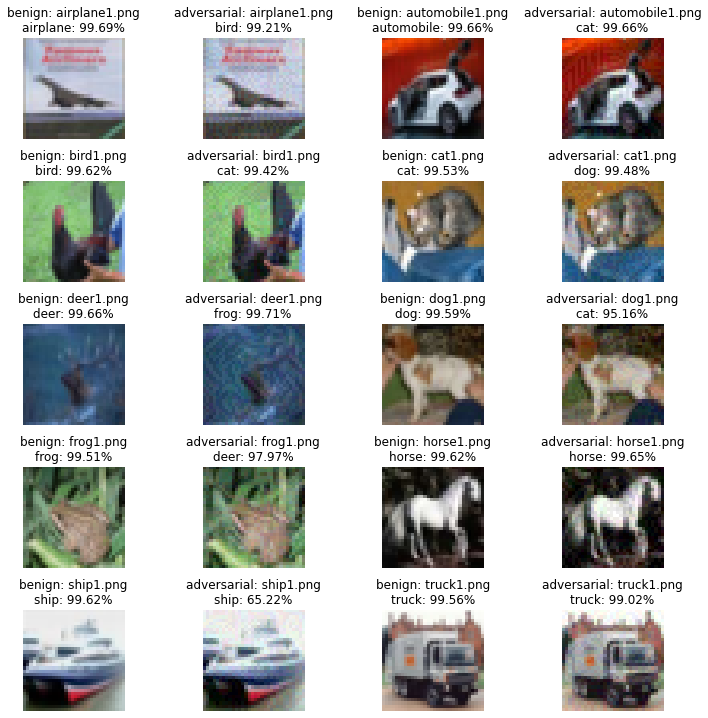

In [ ]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./ifgsm/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()